# ProGAN
In this notebook, we will implement ProGAN to generate different dogs breeds. 
##### Sections
- For Data Importing, [click here](#Data-Importing)
- For FID using InceptionV3, [click here](#InceptionV3-for-FID)
- For Mini Batch Std Deviation, [click here](#Mini-Batch-Standard-Deviation)
- For Pixelwise Feature Normalisation in ProGAN, [click here](#Pixelwise-Feature-Normalisation-in-ProGAN)
- For WGAN-GP Loss Wasserstein Loss with Gradient Penalty, [click here](#WGAN-GP-Loss-(Wasserstein-Loss-with-Gradient-Penalty))
- For ProGAN Generator, [click here](#ProGAN-Generator)
- For ProGAN Discriminator, [click here](#ProGAN-Discriminator)

## Data Importing

The used dataset is Standford Dogs. The dataset contains over 20,000 dogs images of 120 dogs breeds. The following link contains the dataset https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset?resource=download

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

If images and labels are previously saved to `images_numpy.npy` and `labels_numpy.npy` respectively, [click here](#Retrieving-Dataset-as-NumPy-Directly)

The images are stored in a folder called images. Inside this folder, there are subfolders for the each class, where the subfolder is written with the following format: `<code>-<class name>` 

In [ ]:
def get_dataset(folder_name, target_size=(256, 256), shuffle=True):
    folders = os.listdir(folder_name)
    x = []
    y = []
    for ind, folder in enumerate(folders):
        print(f"\rFolder {ind}", end="")
        cur_folder_name = folder_name + '/' + folder
        images = os.listdir(cur_folder_name)
        for img in images:
            img_name = cur_folder_name + '/' + img
            with Image.open(img_name) as x_img:
                x.append(np.array(x_img.resize(target_size)))
            y.append(ind)
            
    print("\rFinished Extracting", end="")
            
    x = np.array(x)
    y = np.array(y)
    
    if shuffle:
        random_idx = np.random.permutation(x.shape[0])
        x = x[random_idx]
        y = y[random_idx]
        
    return x, y

In [ ]:
x, y = get_dataset("Images/")

The below cell will save the images and labels as numpy arrays to easily retrieve them later.

In [ ]:
with open("images_numpy.npy", 'wb') as f:
    np.save(f, x)
    
with open("labels_numpy.npy", 'wb') as f:
    np.save(f, y)

#### Retrieving Dataset as NumPy Directly
If `images_numpy.npy` and `labels_numpy.npy` are previously saved, run the below cell to retrive them fast with loading the images from their root folders.

In [2]:
with open("images_numpy.npy", 'rb') as f:
    x = np.load(f)
    
with open("labels_numpy.npy", 'rb') as f:
    y = np.load(f)

The following function receives a numpy array with at least 16 images. Using Matplotlib, the images will be shown using a 4x4 grid (only 16 images are shown). Inputting the labels and the predictions are optional.

In [3]:
def show_images(images, labels=None, preds=None):
    if images.shape[0] < 16:
        raise Exception("number of images should be 16")
        
    f, ax = plt.subplots(4, 4, figsize=(10, 10))
    cur_img_ind = 0
    for row in range(4):
        for col in range(4):
            ax[row, col].imshow(images[cur_img_ind])
            ax[row, col].axis("off")
            
            title = ""
            if preds is not None:
                title += str(preds[cur_img_ind]) + "/"
            
            if labels is not None:
                title += str(labels[cur_img_ind])
                
            ax[row, col].set_title(title, fontsize=8)
                
            cur_img_ind += 1

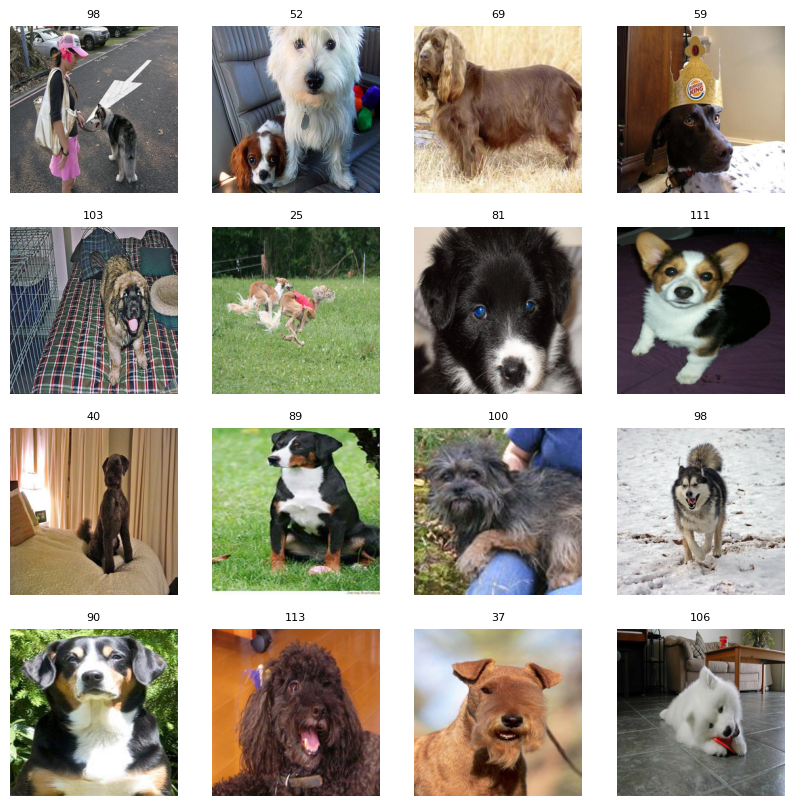

In [4]:
rndm_idx = np.random.choice(x.shape[0], size=16, replace=False)
show_images(x[rndm_idx], y[rndm_idx])

## InceptionV3 for FID

InceptionV3 is used for FID (Frechet Inception Distance). Real and generated images are fed into the InceptionV3 model to output embeddings for each real and generated images. The real and generated images' embeddings are assumed to be sampled from a multivariate gaussian distribution. The closer the distribution of the real and the generated the better. The most common method to measure the "closeness" of these 2 distributions is the Frechet Distance. The Frechet Distance between 2 gaussian normal distributions x & y is given the following equation:
<br></br>
$$
D(x, y) = ||\mu_x - \mu_y||^2 + \text{tr}(\Sigma_x + \Sigma_y - 2\sqrt{\Sigma_x \cdot \Sigma_y})
$$
$\mu_x$: Mean of distribution $x$ (Mean of Generator Embeddings in our case) <br/>
$\mu_y$: Mean of distribution $y$ (Mean of Real Embeddings in our case) <br/>
$\Sigma_x$: Covariance Matrix of distribution $x$ <br/>
$\Sigma_y$: Covariance Matrix of distribution $y$ <br/> 
The first part in this section will include importing and testing the pretrained InceptionV3.
<br></br>
**To jump to to Class FID** [click here](#Class-FID)

In [5]:
import torchvision
import torch

In [6]:
inception_v3 = torchvision.models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT)

In [7]:
inception_v3.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Since PyTorch doesn't have a predefined method of preprocessing InceptionV3, the following function does the preprocessing

In [8]:
def inceptionv3_preprocess(images):
    preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.CenterCrop(299),
        torchvision.transforms.Resize(299),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return torch.stack([preprocess(img) for img in images], axis=0)

Testing the weights of the pretrained model

In [9]:
rndm_idx = np.random.choice(x.shape[0])
test_img = x[rndm_idx]
test_img = np.expand_dims(test_img, axis=0)
test_img.shape

(1, 256, 256, 3)

(-0.5, 255.5, 255.5, -0.5)

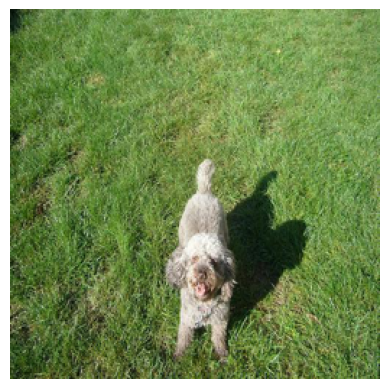

In [10]:
plt.imshow(test_img[0])
plt.axis("off")

In [11]:
preprocessed_img = inceptionv3_preprocess(test_img)
preprocessed_img.shape

torch.Size([1, 3, 299, 299])

Load Imagenet Classes Name

In [12]:
with open("imagenet-classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [13]:
preds = inception_v3(preprocessed_img)[0]
top5_idx = torch.argsort(preds, descending=True)[:5]
[categories[idx] for idx in top5_idx]

['miniature poodle',
 'toy poodle',
 'cocker spaniel, English cocker spaniel, cocker',
 'clumber, clumber spaniel',
 'soft-coated wheaten terrier']

The weights are tested. InceptionV3 predicts at least one of the dog breeds in the top 5 predictions.     

The final dropout and fully connected layers are removed from the model.

In [14]:
inception_v3.dropout = torch.nn.Identity()
inception_v3.fc = torch.nn.Identity()

In [ ]:
inception_v3.eval()

The current output feature vector (Embedding) shape is 2048. 

In [15]:
inception_v3(preprocessed_img).shape

torch.Size([1, 2048])

The following steps freezes all layers in inception model

In [16]:
for param in inception_v3.parameters():
    param.requires_grad = False

#### Class FID 
The function receives the `inception_model` in the constructor and a `preprocessing_func`. When the `__call__` method is called, it preprocesses the real and fake images using the `preprocessing_func`, it then passes the preprocessed images to the `inception_model` to output a feature vector for each image. The equation in [InceptionV3 for FID](#InceptionV3-for-FID) is calculated returning the value. The lower this value is, the better.

In [17]:
from scipy.linalg import sqrtm 

In [18]:
class FID:
    def __init__(self, inception_model, preprocessing_func):
        self.model = inception_model
        self.preprocess = preprocessing_func
        
    def __call__(self, reals, fakes, batch_size=32, verbose=True):
        reals = self.preprocess(reals)
        fakes = self.preprocess(fakes)
        
        if verbose:
            print("Extracting Embeddings for Reals")
        emb_real = self._fwd_model(reals, batch_size=batch_size, verbose=verbose)
        
        if verbose:
            print("Extracting Embeddings for Fakes")
        emb_fakes = self._fwd_model(fakes, batch_size=batch_size, verbose=verbose)
        
        mu_r = self._mean(emb_real)
        mu_f = self._mean(emb_fakes)
        sigma_r = self._cov(emb_real)
        sigma_f = self._cov(emb_fakes)
        
        return self._op(mu_r, mu_f, sigma_r, sigma_f)
    
    def _fwd_model(self, imgs, batch_size, verbose):
        data_gen = torch.utils.data.DataLoader(imgs, batch_size=batch_size, shuffle=True)
        embeddings = None
        for ind, batch in enumerate(data_gen): 
            if verbose:
                print(f"\rBatch {ind}", end="")
            
            if embeddings is None:
                embeddings = self.model(batch)
            else:
                embeddings = torch.cat((embeddings, self.model(batch)), dim=0)
        
        if verbose:
            print() # leave a line
        
        return embeddings.numpy()
        
    @staticmethod
    def _mean(vectors):
        if len(vectors.shape) != 2:
            raise Exception("vectors shape must be (m, n)")
        return np.mean(vectors, axis=0, keepdims=True)
    
    @staticmethod
    def _cov(vectors):
        if len(vectors.shape) != 2:
            raise Exception("vectors shape must be (m, n)")
        return np.cov(vectors, rowvar=False)
    
    @staticmethod
    def _op(mu_x, mu_y, sigma_x, sigma_y):
        mean_distance = np.sum((mu_x - mu_y) ** 2)
        
        sqrt_term = sqrtm(sigma_x @ sigma_y)
        if np.iscomplexobj(sqrt_term):
            sqrt_term = sqrt_term.real
        
        cov_distance = np.trace(sigma_x + sigma_y - 2 * sqrt_term)
        
        return mean_distance + cov_distance

In [19]:
fid_test = FID(inception_v3, inceptionv3_preprocess)

To jump to Mini Batch Standard Deviation, [click here](#Mini-Batch-Standard-Deviation)

##### FID Test 1: No Variation
For FID testing, if the operation is working properly, taking FID for the same images results in a close 0 distance.

In [20]:
rndm_idx = np.random.choice(x.shape[0], size=128)
rndm_idx2 = np.random.permutation(rndm_idx)
reals_test = x[rndm_idx]
fakes_test = x[rndm_idx2]

fid_test(reals_test, fakes_test)

Extracting Embeddings for Reals
Batch 3
Extracting Embeddings for Fakes
Batch 3


-5.350717705515998e-05

##### FID Test 2: Gaussian Blur
The 2nd test is applying a Gaussian Blur on the images and seeing how the FID would change. If FID is working well, it will output a large number.

In [21]:
import cv2

In [22]:
rndm_idx = np.random.choice(x.shape[0], size=128)
reals_test = x[rndm_idx]
fakes_test = np.array([cv2.GaussianBlur(img, (15, 15), 0) for img in reals_test])

fid_test(reals_test, fakes_test)

Extracting Embeddings for Reals
Batch 3
Extracting Embeddings for Fakes
Batch 3


138.1063220054865

##### FID Test 3: Distorting top left corner
The 3rd test is distorting the top left corner in each image and seeing how the FID would change. The distortion occurs by rotating the top left corner 180 degrees. If FID is working well, it will output a large number.

In [23]:
rndm_idx = np.random.choice(x.shape[0], size=128)
reals_test = x[rndm_idx]
cropped_rot = np.array([cv2.rotate(img[0:120, 0:120], cv2.ROTATE_180) for img in reals_test])
fakes_test = np.array([img for img in reals_test])

for ind, _ in enumerate(reals_test):
    fakes_test[ind, 0:120, 0:120] = cropped_rot[ind]

fid_test(reals_test, fakes_test)

Extracting Embeddings for Reals
Batch 3
Extracting Embeddings for Fakes
Batch 3


67.48483366980734

## Mini-Batch Standard Deviation
According to the ProGAN paper in https://arxiv.org/abs/1710.10196, the authors used mini batch std dev layer at the final layers in the discriminator. This layer is explained very well in https://www.youtube.com/watch?v=V1qQXb9KcDY

In [24]:
class MiniBatchStd(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input_tensor):
        # input_tensor: shape (N, C, H, W)
        n = input_tensor.size()[0]
        h = input_tensor.size()[2]
        w = input_tensor.size()[3]

        scalar_mean_std = torch.mean(torch.std(input_tensor, 0))
        final_map = scalar_mean_std.repeat(n, 1, h, w)

        output_tensor = torch.cat((input_tensor, final_map), 1) # Concatenate the final map to the input tensor
        return output_tensor        

In [25]:
test_tensor = torch.rand(128, 32, 7, 7)
MiniBatchStd()(test_tensor).size() # Should be (128, 33, 7, 7)

torch.Size([128, 33, 7, 7])

## Pixelwise Feature Normalisation in ProGAN
According to the ProGAN paper in https://arxiv.org/abs/1710.10196, the authors used local response normalisation with certain configuration and called it pixelwise feature normalisation. The configured equation is:
$$
b_{x,y}^i = \frac{a_{x,y}^i}{\sqrt{\frac{1}{N}\sum_{j=0}^{N-1} \left(a_{x,y}^{j}\right)^2 + \epsilon}}
$$
$a_{x,y}^i$ is the original pixel located at $(x,y)$ at channel number $i$ </br>
$b_{x,y}^i$ is the normalized pixel located at $(x,y)$ at channel number $i$ </br>
$N$ is the number of channels </br>
$\epsilon$ is set to $10^{-8}$ to avoid division by zero </br>

In [26]:
class PixelwiseNorm(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input_tensor, epsilon=1e-8):
        # input_tensor: shape (N, C, H, W)
        divisor = torch.sqrt(torch.mean(input_tensor**2.0, dim=1, keepdim=True) + epsilon)
        output_tensor = input_tensor / divisor
        return output_tensor

In [27]:
test_tensor = torch.rand(128, 32, 7, 7)
PixelwiseNorm()(test_tensor).shape

torch.Size([128, 32, 7, 7])

## WGAN-GP Loss (Wasserstein Loss with Gradient Penalty)
The authors of ProGAN paper used the Wasserstein loss with gradient penalty explained in the paper ("Improved Training of Wasserstein GANs") in https://arxiv.org/abs/1704.00028. The autors of ProGAN added a fourth term to the critic's (discriminator's) loss function to prevent the discriminator's output from drifiting too far from 0 (to further guarantee stability in training). Thus, the loss function of the discriminator is:
$$
L_d = \mathbb{E}_{x_g\sim\mathbb{P}_g}[D(x_g)] - \mathbb{E}_{x_r\sim\mathbb{P}_r}[D(x_r)] + \lambda \mathbb{E}_{x\sim\mathbb{P}_x}[(||\nabla D(x)|| - 1)^2]+\epsilon_{drift}\mathbb{E}_{x_r\sim\mathbb{P}_r}[D(x_r)^2]
$$
where
$$
x = \epsilon x_r + (1-\epsilon) x_g
$$
Intuitively, minimizing the first 2 terms in this loss function means forcing the generated images to output small numbers from the discriminator, and forcing the real images to output large numbers. The 3rd and 4th terms helps in stability during training for the GAN. Each term is explained in the following bullet points:
- The first term means that we should generate some images, sample from these images, feed these sampled images to the discriminator, the output of the discriminator should belong to $\mathbb{R}^N$ (where $N$ is the number of sampled generated images). These $N$ values are then averaged to find the first term of the equation.
- The second term means that we should sample from some real images, feed these sampled images to the discriminator, the output of the discriminator should also belong to $\mathbb{R}^N$ (where $N$ is the number of sampled sampled real images). These $N$ values are then averaged and multiplied by negative to find the second term of the equation.
- The third term of the equation tries to force the 1-Lipschtiz continuity of the discriminator function. 1-Lipschtiz continuity for a function means that this function's gradient magnitude does not surpass value of 1 on its whole domain. The third term penalizes any value other than 1 for the gradient's magnitude.
- The fourth term, as mentioned, was added by the ProGAN authors to prevent the discriminator's output from drifiting too far from 0.
</br></br>
The loss function of the generator is much simpler that includes only one term:
$$
L_g = -\mathbb{E}_{x_g\sim\mathbb{P}_g}[D(x_g)]
$$
The intuition about this loss function is that the generator tries to fool the discriminator. Now, the generator want to output large numbers from the discriminator. The larger these numbers the less loss. 

In [28]:
class WassersteinGradientPenalty:
    def __init__(self, lmbda=10, epsilon_drift=0.001):
        super().__init__()
        self.lmbda = lmbda
        self.epsilon_drift = epsilon_drift
        
    def disc_loss(self, reals, fakes, disc_nn):
        # reals: shape (N, C, H, W)
        # fakes: shape (N, C, H, W)
        fakes = fakes.detach()
        
        n_r = reals.size()[0]
        n_f = fakes.size()[0]
        
        if n_r != n_f:
            raise Exception("batch number in reals and fakes must be equal")
            
        epsilon = torch.rand(n_r, 1, 1, 1)
        x = epsilon * reals + (1-epsilon) * fakes
        
        # print(x[0])
        # print(x[1])
        
        x.requires_grad = True
        
        d_real = disc_nn(reals)
        d_fake = disc_nn(fakes)
        d_x = disc_nn(x)
        
        first_term = torch.mean(d_fake)
        second_term = -torch.mean(d_real)
        
        gradient = torch.autograd.grad(
            outputs=torch.sum(d_x), # Further explained in the next markdown cell.   
            inputs=x,
            retain_graph=True,
            create_graph=True # Create graph of the derivatives to compute the higher order derivatives
        )[0]
        
        gradient = torch.reshape(gradient, (gradient.size()[0], -1))
        norm = torch.norm(gradient, dim=1)
        
        third_term = self.lmbda * torch.mean((norm - 1) ** 2)
        fourth_term = self.epsilon_drift * torch.mean(d_real**2)
        
        loss = first_term + second_term + third_term + fourth_term
        
        return loss
    
    def gen_loss(self, fakes, disc_nn, reals=None):
        d_fake = disc_nn(fakes)
        first_term = torch.mean(d_fake)
        loss = -first_term
        
        if reals is not None:
            d_real = disc_nn(reals)
            second_term = torch.mean(d_real)
            loss += second_term
            
        return loss

#### Note
```
        gradient = torch.autograd.grad(
            outputs=torch.sum(d_x), 
            inputs=x,
            retain_graph=True,
            create_graph=True
        )[0]
```
is equaivalent to
```
        gradient = torch.autograd.grad(
            outputs=d_x, 
            inputs=x,
            grad_outputs=torch.ones_like(d_x)
            retain_graph=True,
            create_graph=True
        )[0]
```
The first code snippet just sums all the values in the discriminator's output for a scalar value. The second code snippet multiplies the final jacobians with ones. Why are these 2 equivalent? </br>
The following example explains why they are equivalent </br>
Assume that:
$$
x = \begin{bmatrix}
x_1 \\
x_2
\end{bmatrix},
y = \begin{bmatrix}
y_1 \\
y_2
\end{bmatrix},
A = \begin{bmatrix}
1&2 \\
3&4
\end{bmatrix}
$$
Also assume that:
$$
y=Ax
$$
$$
\begin{bmatrix}
y_1 \\
y_2
\end{bmatrix}
=\begin{bmatrix}
1&2 \\
3&4
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
$$
If we summed up the output values (like first code snippet):
$$
S = y_1 + y_2
$$
Then
$$
\frac{dS}{dx} = \frac{dy_1}{dx} + \frac{dy_2}{dx}
$$
We can say that
$$
y_1 = \begin{bmatrix}
1&2
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
$$
&
$$
y_2 = \begin{bmatrix}
3&4
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
$$
Finding the jacobian for $y_1$
$$
\frac{dy_1}{dx} = \begin{bmatrix}
1&2
\end{bmatrix}
$$
Finding the jacobian for $y_2$
$$
\frac{dy_2}{dx} = \begin{bmatrix}
3&4
\end{bmatrix}
$$
Then
$$
\frac{dS}{dx} = \begin{bmatrix}
\mathbf{4}&\mathbf{6}
\end{bmatrix}
$$
For the second code snippet, we find $\frac{dy}{dx}$ (taking the jacboian of $y$) and then multiply the result with vector of ones:
$$
\frac{dy}{dx} = A = \begin{bmatrix}
1&2 \\
3&4
\end{bmatrix}
$$
Multiplying $\frac{dy}{dx}$ by vector of ones:
$$
\begin{bmatrix}
1&1
\end{bmatrix}
\begin{bmatrix}
1&2 \\
3&4
\end{bmatrix}=\begin{bmatrix}
\mathbf{4}&\mathbf{6}
\end{bmatrix}
$$

The following code cell creates dummy tensor for fakes of shape (2, 2, 2, 2) to test the loss function

In [29]:
fake = torch.FloatTensor([
    [
        [1, 2],
        [3, 4]
    ],
    [
        [5, 6],
        [7, 8]
    ]
])
fake = fake.unsqueeze(0)
fake = torch.cat([fake, fake], 0)
fake.shape

torch.Size([2, 2, 2, 2])

The following code cell creates dummy tensor for reals of shape (2, 2, 2, 2) to test the loss function

In [30]:
real = torch.FloatTensor([
    [
        [10, 11],
        [12, 13]
    ],
    [
        [14, 15],
        [16, 17]
    ]
])
real = real.unsqueeze(0)
real = torch.cat([real, real], 0)
real.shape

torch.Size([2, 2, 2, 2])

The following code is a dummy function for the discriminator (for testing purposes only)

In [31]:
class DummyDiscFunc:
    def __init__(self):
        pass
    def __call__(self, x):
        return torch.sum(torch.reshape(0.5*x**2, (x.shape[0], -1)), 1, keepdim=True)
    
disc_func = DummyDiscFunc()
disc_func(real)

tensor([[750.],
        [750.]])

In [32]:
loss_test = WassersteinGradientPenalty()

In [33]:
loss_test.disc_loss(real, fake, disc_func)

tensor(3460.0742, grad_fn=<AddBackward0>)

In [34]:
loss_test.gen_loss(fake, disc_func)

tensor(-102.)

## ProGAN Generator
In the appendix in ProGAN paper, they showed the generator's architecture. The architecture is:
<img src="Markdown_Images/Gen_Arch.png" alt="Generator Architecture" width="400"/>
There are some changes differences between the model implemented in this notebook and the ProGAN in the actual paper. The changes are:
- No equalized learning rate. Instead, kernels are initialized using He-Normal.
- Images generated will be 256x256. The paper generated images of resolution 1024x1024.
- Used FID, explained [here](#InceptionV3-for-FID), instead of inception score.
</br>
One of the major operations the paper of ProGAN did was the fade in operation described in the following picture:
<img src="Markdown_Images/Gen_Fade_In.png" alt="Generator Fade In" width="400"/>
The "2x" corresponds to upsampling using nearest neighbour. The "toRGB" block is composed of 1x1 convolution operation with 3 filters.

In [35]:
class Generator(torch.nn.Module):
    def __init__(self, log2_target_res=8, weights_path=None):
        """log2_target_res means that the resolution of the output image is required to be 2^log2_target_res
        Example: 2^8 = 256. That means that the target resolution of the generated images is 256*256 """
        super().__init__()
        
        channels = [512, 512, 512, 512, 256, 128, 64, 32, 16]
        num_of_sub_models = log2_target_res - 2
        
        if num_of_sub_models < 0:
            raise Exception("resolution of the image cannot be less than 4*4")
        if num_of_sub_models > 8:
            raise Exception("resolution of the image cannot be more than 1024*1024")
            
        self.start_block = self._start_block()
        self.conv_blocks = torch.nn.ModuleList([])
        self.upsample_block = torch.nn.Upsample(scale_factor=2, mode="nearest")
        self.rgb_blocks = torch.nn.ModuleList([])
        
        self.cur_growth = 0
        
        for ind in range(num_of_sub_models):
            in_channels = channels[ind]
            out_channels = channels[ind+1]
            
            sub_model = self._conv_block(in_channels, out_channels)
            rgb_block = self._rgb_block(out_channels)
            
            self.conv_blocks.append(sub_model)
            self.rgb_blocks.append(rgb_block)
        
        if weights_path is None:
            self._init_weights()
        else:
            self.load_weights(weights_path)
    
    def _start_block(self):
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(512, 512, kernel_size=4),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            PixelwiseNorm(),
        )
    
    def _conv_block(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode="nearest"),
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            PixelwiseNorm(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            PixelwiseNorm()
        )
    
    def _rgb_block(self, in_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 3, kernel_size=1),
            torch.nn.Tanh()
        )
    
    def _init_weights(self):
        params = iter(self.parameters())
        
        for ind, param in enumerate(params):
            if ind % 2 == 0:
                torch.nn.init.kaiming_normal_(param) # Kernel He init
            else:
                torch.nn.init.zeros_(param) # Bias init
                
    def save_weights(self, path):
        model_data = self.state_dict()
        model_data["cur_growth"] = self.cur_growth # Add cur_growth to the dict to be saved
        torch.save(model_data, path)
        
    def load_weights(self, path):
        model_data = torch.load(path)
        self.cur_growth = model_data["cur_growth"] # Read cur_growth
        model_data.pop("cur_growth") # Remove cur_growth from dict
        self.load_state_dict(model_data)
        
    def grow(self):
        self.cur_growth += 1
        if self.cur_growth >= (len(self.conv_blocks) + 1):
            raise Exception("Generator cannot be grown further")
        
    def get_cur_growth(self):
        return get_cur_growth
    
    def forward(self, x, alpha=1):
        y_hat = self.start_block(x)
        
        for cur_lyr in range(self.cur_growth-1):
            y_hat = self.conv_blocks[cur_lyr](y_hat)
        
        if self.cur_growth > 0:
            conv = self.conv_blocks[self.cur_growth-1](y_hat)
            upsample = self.upsample_block(y_hat)
            
            rgb_lyr_conv = self.rgb_blocks[self.cur_growth-1](conv)
            if self.cur_growth == 1:
                rgb_lyr_upsample = self.rgb_blocks[self.cur_growth-1](upsample)
            else:
                rgb_lyr_upsample = self.rgb_blocks[self.cur_growth-2](upsample)
            
            y_hat = alpha * rgb_lyr_conv + (1 - alpha) * rgb_lyr_upsample
        else:
            y_hat = self.rgb_blocks[0](y_hat)
            
        return y_hat

In [36]:
def test_gen():
    gen = Generator()
    test_in = torch.randn(2, 512, 1, 1)
    while True:
        cur_sz = gen(test_in).size()
        print(f"Output size is {cur_sz}")
        try:
            gen.grow()
        except Exception:
            break

In [37]:
test_gen()

Output size is torch.Size([2, 3, 4, 4])
Output size is torch.Size([2, 3, 8, 8])
Output size is torch.Size([2, 3, 16, 16])
Output size is torch.Size([2, 3, 32, 32])
Output size is torch.Size([2, 3, 64, 64])
Output size is torch.Size([2, 3, 128, 128])
Output size is torch.Size([2, 3, 256, 256])


## ProGAN Discriminator
In the appendix in ProGAN paper, they showed the generator's architecture. The architecture is:
<img src="Markdown_Images/Disc_Arch.png" alt="Discriminator Architecture" width="400"/>
There are some changes differences between the model implemented in this notebook and the ProGAN in the actual paper. The changes are:
- No equalized learning rate. Instead, kernels are initialized using He-Normal.
- Images generated will be 256x256. The paper generated images of resolution 1024x1024.
- Used FID, explained [here](#InceptionV3-for-FID), instead of inception score.
</br>
One of the major operations the paper of ProGAN did was the fade in operation described in the following picture:
<img src="Markdown_Images/Disc_Fade_In.png" alt="Discriminator Fade In" width="400"/>
The "0.5x" corresponds to downsampling using average pooling. The "fromRGB" block is composed of 1x1 convolution operation.

In [38]:
class Discriminator(torch.nn.Module):
    def __init__(self, log2_target_res=8, weights_path=None):
        """log2_target_res means that the resolution of the output image is required to be 2^log2_target_res
        Example: 2^8 = 256. That means that the target resolution of the generated images is 256*256 """
        super().__init__()
        
        channels = [512, 512, 512, 512, 256, 128, 64, 32, 16]
        self.num_of_sub_models = log2_target_res - 2
        
        if self.num_of_sub_models < 0:
            raise Exception("resolution of the input images cannot be less than 4*4")
        if self.num_of_sub_models > 8:
            raise Exception("resolution of the input images cannot be more than 1024*1024")
        
        self.rgb_blocks = torch.nn.ModuleList([])
        self.conv_blocks = torch.nn.ModuleList([])
        self.downsample_block = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.end_block = self._end_block()
        
        self.cur_growth = 0
        
        for ind in range(self.num_of_sub_models):
            in_channels = channels[ind+1]
            out_channels = channels[ind]
            
            rgb_block = self._rgb_block(in_channels)
            sub_model = self._conv_block(in_channels, out_channels)
            
            self.rgb_blocks.insert(0, rgb_block)
            self.conv_blocks.insert(0, sub_model)
            
        if weights_path is None:
            self._init_weights()
        else:
            self.load_weights(weights_path)
    
    def _rgb_block(self, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(3, out_channels, kernel_size=1),
            torch.nn.LeakyReLU(0.2)
        )
    
    def _conv_block(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
        )
    
    def _end_block(self):
        return torch.nn.Sequential(
            MiniBatchStd(),
            torch.nn.Conv2d(513, 512, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(512, 512, kernel_size=4),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Flatten(),
            torch.nn.Linear(512, 1)
        )
            
    def _init_weights(self):
        params = iter(self.parameters())
        
        for ind, param in enumerate(params):
            if ind % 2 == 0:
                torch.nn.init.kaiming_normal_(param) # Kernel He init
            else:
                torch.nn.init.zeros_(param) # Bias init
            
    def grow(self):
        self.cur_growth += 1
        if self.cur_growth >= (len(self.conv_blocks) + 1):
            raise Exception("Discriminator cannot be grown further")
    
    def save_weights(self, path):
        model_data = self.state_dict()
        model_data["cur_growth"] = self.cur_growth # Add cur_growth to the dict to be saved
        torch.save(model_data, path)
        
    def load_weights(self, path):
        model_data = torch.load(path)
        self.cur_growth = model_data["cur_growth"] # Read cur_growth
        model_data.pop("cur_growth") # Remove cur_growth from dict
        self.load_state_dict(model_data)
    
    def forward(self, x, alpha=1):
        ind = self.num_of_sub_models - self.cur_growth
        if self.cur_growth > 0:
            downsampled = self.downsample_block(x)
            if self.cur_growth == 1:
                rgb_downsampled_lyr = self.rgb_blocks[ind](downsampled)
            else:        
                rgb_downsampled_lyr = self.rgb_blocks[ind+1](downsampled)
            
            rgb = self.rgb_blocks[ind](x)
            rgb_conv_lyr = self.conv_blocks[ind](rgb)
            
            y_hat = alpha * rgb_conv_lyr + (1 - alpha) * rgb_downsampled_lyr
        else:
            y_hat = self.rgb_blocks[-1](x)
        
        for cur_lyr in range(ind+1, self.num_of_sub_models):
            y_hat = self.conv_blocks[cur_lyr](y_hat)
        
        y_hat = self.end_block(y_hat)
        
        return y_hat

In [39]:
def test_disc():
    disc = Discriminator()
    dim = 4
    while True:
        test_in = torch.randn(2, 3, dim, dim)
        cur_sz = disc(test_in).size()
        print(f"Input size is {test_in.size()}.. Output size is {cur_sz}")
        try:
            disc.grow()
        except Exception:
            break
        else:
            dim *= 2

In [40]:
test_disc()

Input size is torch.Size([2, 3, 4, 4]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 8, 8]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 16, 16]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 32, 32]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 64, 64]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 128, 128]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 256, 256]).. Output size is torch.Size([2, 1])
